# **Assignment 2: Convolution Sudarshan Rayapati**

In [1]:
from google.colab import drive
import zipfile
import os

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# Directory containing the extracted files
extracted_dir_path = '/content/drive/MyDrive'

# List all files in the directory
files = os.listdir(extracted_dir_path)

print(files)

['cats_vs_dogs_small_dataset.zip', 'Colab Notebooks', 'cats_vs_dogs_small_dataset']


In [4]:
# Path to the zip file
zip_file_path = '/content/drive/My Drive/cats_vs_dogs_small_dataset.zip'

# Directory to extract the files
extracted_dir_path = '/content/drive/My Drive/cats_vs_dogs_small_dataset'

In [ ]:

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# Check the extracted files
extracted_files = os.listdir(extracted_dir_path)
print("Files extracted successfully:", extracted_files)


In [5]:
# Path to the 'cat' and 'dog' folders
cat_folder_path = os.path.join(extracted_dir_path, 'cat')
dog_folder_path = os.path.join(extracted_dir_path, 'dog')

# Function to count the number of images in a folder
def count_images(folder_path):
    # List all files in the directory
    files = os.listdir(folder_path)
    # Count only files with .jpg or .png extension
    image_files = [file for file in files if file.endswith('.jpg') or file.endswith('.png')]
    return len(image_files)

# Count the number of images in the 'cat' and 'dog' folders
num_cat_images = count_images(cat_folder_path)
num_dog_images = count_images(dog_folder_path)

# Display the results
print("Number of images in 'cat' folder:", num_cat_images)
print("Number of images in 'dog' folder:", num_dog_images)

Number of images in 'cat' folder: 2000
Number of images in 'dog' folder: 2000


1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a
validation sample of 500, and a test sample of 500 (like in the text). Use any technique
to reduce overfitting and improve performance in developing a network that you train
from scratch. What performance did you achieve?

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import os
import shutil
import random

Splitting The Dataset

In [7]:
base_dir = '/content/cats_vs_dogs_dataset'
os.makedirs(base_dir, exist_ok=True)
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

In [8]:
train_cats_dir = os.path.join(train_dir, 'cat')
os.makedirs(train_cats_dir, exist_ok=True)
train_dogs_dir = os.path.join(train_dir, 'dog')
os.makedirs(train_dogs_dir, exist_ok=True)

validation_cats_dir = os.path.join(validation_dir, 'cat')
os.makedirs(validation_cats_dir, exist_ok=True)
validation_dogs_dir = os.path.join(validation_dir, 'dog')
os.makedirs(validation_dogs_dir, exist_ok=True)

test_cats_dir = os.path.join(test_dir, 'cat')
os.makedirs(test_cats_dir, exist_ok=True)
test_dogs_dir = os.path.join(test_dir, 'dog')
os.makedirs(test_dogs_dir, exist_ok=True)

In [9]:
def copy_images(src_dir, dst_dir, file_list):
    for file in file_list:
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(dst_dir, file)
        shutil.copyfile(src_path, dst_path)

In [10]:
cat_images = os.listdir(cat_folder_path)
dog_images = os.listdir(dog_folder_path)

random.shuffle(cat_images)
random.shuffle(dog_images)

In [11]:
train_samples = 1000
validation_samples = 500
test_samples = 500

In [12]:
copy_images(cat_folder_path, train_cats_dir, cat_images[:train_samples//2])
copy_images(dog_folder_path, train_dogs_dir, dog_images[:train_samples//2])

copy_images(cat_folder_path, validation_cats_dir, cat_images[train_samples//2:train_samples//2 + validation_samples//2])
copy_images(dog_folder_path, validation_dogs_dir, dog_images[train_samples//2:train_samples//2 + validation_samples//2])

copy_images(cat_folder_path, test_cats_dir, cat_images[train_samples//2 + validation_samples//2:train_samples//2 + validation_samples//2 + test_samples//2])
copy_images(dog_folder_path, test_dogs_dir, dog_images[train_samples//2 + validation_samples//2:train_samples//2 + validation_samples//2 + test_samples//2])

In [13]:
batch_size = 20
image_size = (150, 150)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Model Definition

In [14]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

Training the Model

In [15]:
# Define parameters for training
epochs = 10

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size
)

Epoch 1/10
50/50 [==============================] - 36s 699ms/step - loss: 0.7013 - accuracy: 0.5040 - val_loss: 0.6882 - val_accuracy: 0.5000
Epoch 2/10
50/50 [==============================] - 39s 790ms/step - loss: 0.6938 - accuracy: 0.5290 - val_loss: 0.6897 - val_accuracy: 0.5720
Epoch 3/10
50/50 [==============================] - 36s 711ms/step - loss: 0.6857 - accuracy: 0.5490 - val_loss: 0.6719 - val_accuracy: 0.5580
Epoch 4/10
50/50 [==============================] - 35s 691ms/step - loss: 0.6815 - accuracy: 0.5360 - val_loss: 0.6760 - val_accuracy: 0.5580
Epoch 5/10
50/50 [==============================] - 34s 684ms/step - loss: 0.6712 - accuracy: 0.5970 - val_loss: 0.6553 - val_accuracy: 0.5740
Epoch 6/10
50/50 [==============================] - 34s 680ms/step - loss: 0.6559 - accuracy: 0.5990 - val_loss: 0.6465 - val_accuracy: 0.6160
Epoch 7/10
50/50 [==============================] - 34s 681ms/step - loss: 0.6561 - accuracy: 0.5860 - val_loss: 0.6640 - val_accuracy: 0.5900

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_samples // batch_size)
print("Test accuracy:", test_accuracy)

25/25 [==============================] - 5s 181ms/step - loss: 0.6759 - accuracy: 0.5460
Test accuracy: 0.5460000038146973


Perfomance Metrics

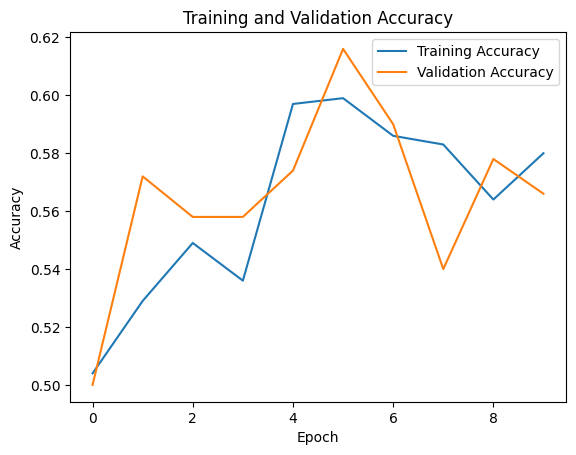

In [17]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


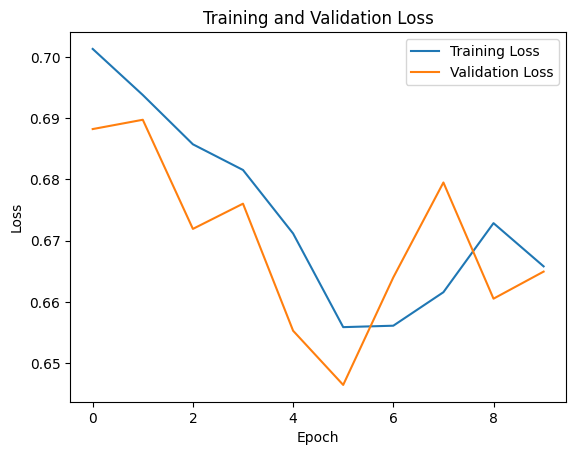

In [18]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

2. Increase your training sample size. You may pick any amount. Keep the validation and
test samples the same as above. Optimize your network (again training from scratch).
What performance did you achieve?

Splitting The Dataset

In [22]:
# Paths to the 'cat' and 'dog' folders
cat_folder_path = '/content/drive/MyDrive/cats_vs_dogs_small_dataset/cat'
dog_folder_path = '/content/drive/MyDrive/cats_vs_dogs_small_dataset/dog'

# Define new sample sizes
new_train_samples = 2000

# Copy images to training directory
copy_images(cat_folder_path, train_cats_dir, cat_images[:new_train_samples//2])
copy_images(dog_folder_path, train_dogs_dir, dog_images[:new_train_samples//2])

# Create ImageDataGenerator for training set with augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.


Training the model

In [24]:
# Define parameters for training
epochs = 10

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=new_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_samples // batch_size)
print("Test accuracy with increased training sample size:", test_accuracy)


Epoch 1/10
100/100 [==============================] - 64s 641ms/step - loss: 0.5881 - accuracy: 0.6870 - val_loss: 0.5327 - val_accuracy: 0.7280
Epoch 2/10
100/100 [==============================] - 64s 641ms/step - loss: 0.5934 - accuracy: 0.6745 - val_loss: 0.5311 - val_accuracy: 0.7520
Epoch 3/10
100/100 [==============================] - 65s 647ms/step - loss: 0.5693 - accuracy: 0.7060 - val_loss: 0.5224 - val_accuracy: 0.7480
Epoch 4/10
100/100 [==============================] - 65s 650ms/step - loss: 0.5803 - accuracy: 0.6895 - val_loss: 0.5420 - val_accuracy: 0.7080
Epoch 5/10
100/100 [==============================] - 63s 632ms/step - loss: 0.5869 - accuracy: 0.6935 - val_loss: 0.5203 - val_accuracy: 0.7480
Epoch 6/10
100/100 [==============================] - 65s 646ms/step - loss: 0.5724 - accuracy: 0.7025 - val_loss: 0.5686 - val_accuracy: 0.7160
Epoch 7/10
100/100 [==============================] - 64s 637ms/step - loss: 0.5733 - accuracy: 0.7035 - val_loss: 0.4933 - val_ac

In [25]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_samples // batch_size)
print("Test accuracy:", test_accuracy)

25/25 [==============================] - 4s 167ms/step - loss: 0.5214 - accuracy: 0.7140
Test accuracy: 0.7139999866485596


Perfomance Metrics

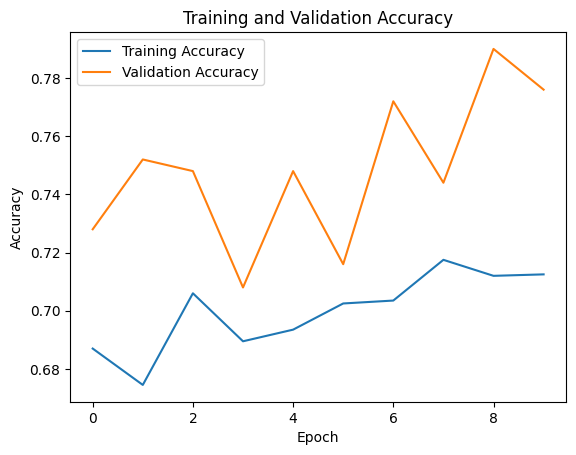

In [26]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

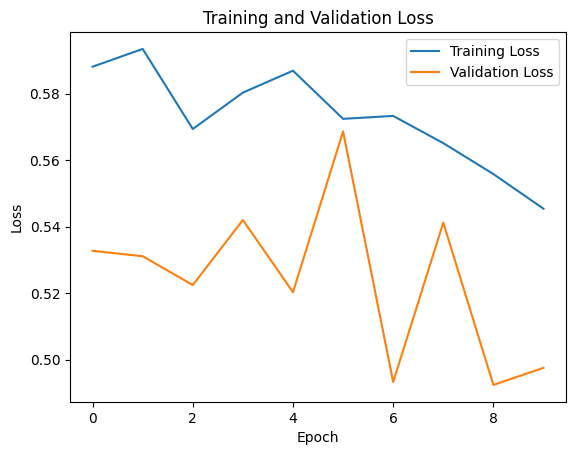

In [27]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

3. Now change your training sample so that you achieve better performance than those
from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous
steps. The objective is to find the ideal training sample size to get best prediction
results

Choosing different training samples

In [28]:
training_sample_sizes = [500, 1000, 1500, 2000, 2500]

Training the Models on different test samples

In [35]:
# Iterate over the list of training sample sizes
for sample_size in training_sample_sizes:
    # Clear the existing training directory
    shutil.rmtree(train_dir)
    os.makedirs(train_dir, exist_ok=True)
    train_cats_dir = os.path.join(train_dir, 'cat')
    os.makedirs(train_cats_dir, exist_ok=True)
    train_dogs_dir = os.path.join(train_dir, 'dog')
    os.makedirs(train_dogs_dir, exist_ok=True)

    # Copy images to training directory based on the current sample size
    copy_images(cat_folder_path, train_cats_dir, cat_images[:sample_size//2])
    copy_images(dog_folder_path, train_dogs_dir, dog_images[:sample_size//2])

    # Create ImageDataGenerator for training set with augmentation
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=sample_size // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_samples // batch_size,
        verbose=0  # Disable verbose output for cleaner logging
    )

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_samples // batch_size, verbose=0)
    test_accuracies.append(test_accuracy)

    print(f"Test accuracy with training sample size {sample_size}: {test_accuracy}")

# Find the best performing training sample size
best_sample_size = training_sample_sizes[test_accuracies.index(max(test_accuracies))]
print(f"\nBest performing training sample size: {best_sample_size} with test accuracy: {max(test_accuracies)}")

Found 500 images belonging to 2 classes.
Test accuracy with training sample size 500: 0.7120000123977661
Found 1000 images belonging to 2 classes.
Test accuracy with training sample size 1000: 0.7160000205039978
Found 1500 images belonging to 2 classes.
Test accuracy with training sample size 1500: 0.734000027179718
Found 2000 images belonging to 2 classes.
Test accuracy with training sample size 2000: 0.7919999957084656
Found 2500 images belonging to 2 classes.
Test accuracy with training sample size 2500: 0.8519999980926514

Best performing training sample size: 2500 with test accuracy: 0.8519999980926514


In [36]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_samples // batch_size)
print("Test accuracy:", test_accuracy)

25/25 [==============================] - 8s 315ms/step - loss: 0.3270 - accuracy: 0.8520
Test accuracy: 0.8519999980926514


Evaluation Metrics

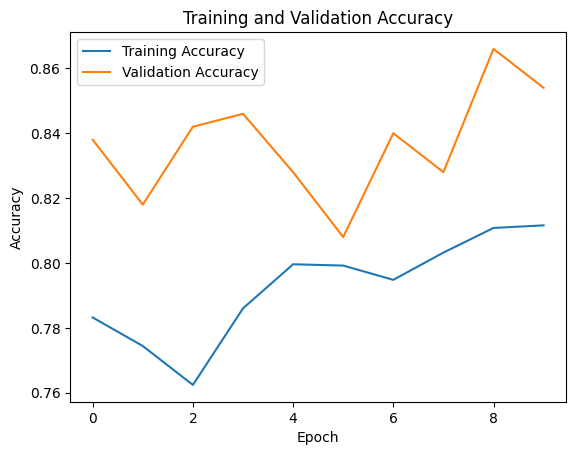

In [37]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

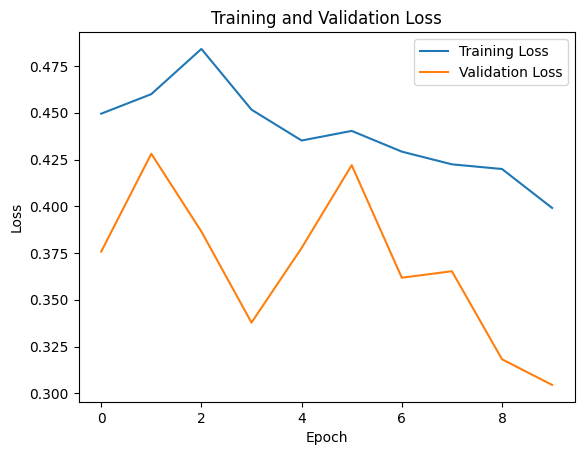

In [38]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in
Steps 2 and 3 for the pretrained network may be the same or different from those using
the network where you trained from scratch. Again, use any and all optimization
techniques to get best performance.

In [39]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

Using ResNet

In [40]:
# Load pre-trained ResNet50 model without the top classification layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [41]:
# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

For Training Sample of Size 1000

In [43]:
# Clear existing data in the training directory
shutil.rmtree(train_dir)
os.makedirs(train_dir, exist_ok=True)

train_cats_dir = os.path.join(train_dir, 'cat')
os.makedirs(train_cats_dir, exist_ok=True)
train_dogs_dir = os.path.join(train_dir, 'dog')
os.makedirs(train_dogs_dir, exist_ok=True)

# Assign 500 cat and 500 dog images to the training directory
def copy_images(source_dir, destination_dir, images):
    for image in images:
        shutil.copy(os.path.join(source_dir, image), destination_dir)

# Randomize the order of cat and dog images
random.shuffle(cat_images)
random.shuffle(dog_images)

# Copy images to training directory
copy_images(cat_folder_path, train_cats_dir, cat_images[:500])
copy_images(dog_folder_path, train_dogs_dir, dog_images[:500])

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators for training, validation, and testing
batch_size = 20
image_size = (150, 150)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.


Runnning The Model

In [46]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=1000 // batch_size,  # 1000 images in total (500 cat + 500 dog)
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size
)

Epoch 1/10
50/50 [==============================] - 105s 2s/step - loss: 1.0692 - accuracy: 0.5050 - val_loss: 0.6885 - val_accuracy: 0.5000
Epoch 2/10
50/50 [==============================] - 101s 2s/step - loss: 0.6928 - accuracy: 0.5180 - val_loss: 0.6672 - val_accuracy: 0.5940
Epoch 3/10
50/50 [==============================] - 86s 2s/step - loss: 0.6998 - accuracy: 0.5230 - val_loss: 0.7027 - val_accuracy: 0.5000
Epoch 4/10
50/50 [==============================] - 101s 2s/step - loss: 0.6888 - accuracy: 0.5350 - val_loss: 0.6523 - val_accuracy: 0.6160
Epoch 5/10
50/50 [==============================] - 87s 2s/step - loss: 0.6762 - accuracy: 0.5810 - val_loss: 0.6677 - val_accuracy: 0.5400
Epoch 6/10
50/50 [==============================] - 101s 2s/step - loss: 0.6999 - accuracy: 0.5590 - val_loss: 0.6537 - val_accuracy: 0.6160
Epoch 7/10
50/50 [==============================] - 86s 2s/step - loss: 0.6864 - accuracy: 0.5530 - val_loss: 0.6449 - val_accuracy: 0.6460
Epoch 8/10
50/50

In [47]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_samples // batch_size)
print("Test accuracy:", test_accuracy)

25/25 [==============================] - 27s 1s/step - loss: 0.7303 - accuracy: 0.5200
Test accuracy: 0.5199999809265137


Perfomance Metrics

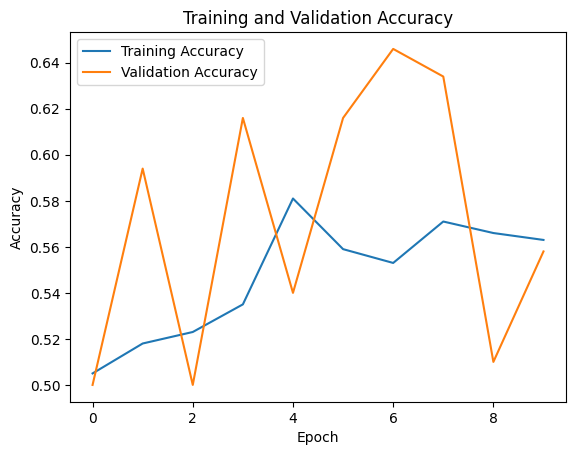

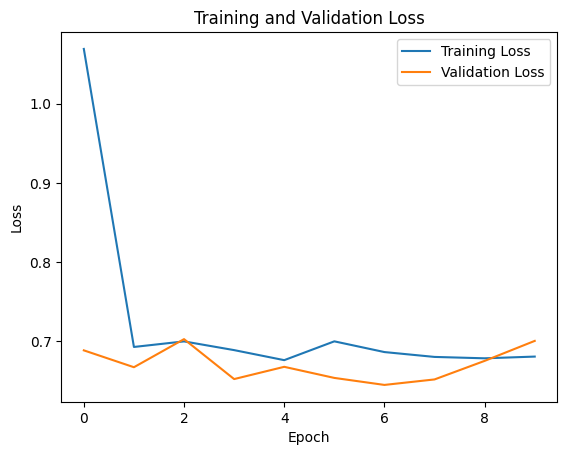

In [50]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

For Training Samples of size 1500

In [49]:
# Clear existing data in the training directory
shutil.rmtree(train_dir)
os.makedirs(train_dir, exist_ok=True)

train_cats_dir = os.path.join(train_dir, 'cat')
os.makedirs(train_cats_dir, exist_ok=True)
train_dogs_dir = os.path.join(train_dir, 'dog')
os.makedirs(train_dogs_dir, exist_ok=True)

# Assign 500 cat and 500 dog images to the training directory
def copy_images(source_dir, destination_dir, images):
    for image in images:
        shutil.copy(os.path.join(source_dir, image), destination_dir)

# Randomize the order of cat and dog images
random.shuffle(cat_images)
random.shuffle(dog_images)

# Copy images to training directory
copy_images(cat_folder_path, train_cats_dir, cat_images[:750])
copy_images(dog_folder_path, train_dogs_dir, dog_images[:750])

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators for training, validation, and testing
batch_size = 20
image_size = (150, 150)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 1500 images belonging to 2 classes.


In [51]:
# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

Training the Model

In [53]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=1500 // batch_size,  # 1500 images in total (750 cat + 750 dog)
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size
)

Epoch 1/10
75/75 [==============================] - 118s 2s/step - loss: 0.7582 - accuracy: 0.5293 - val_loss: 0.6655 - val_accuracy: 0.5820
Epoch 2/10
75/75 [==============================] - 117s 2s/step - loss: 0.6777 - accuracy: 0.5620 - val_loss: 0.6520 - val_accuracy: 0.6340
Epoch 3/10
75/75 [==============================] - 132s 2s/step - loss: 0.7155 - accuracy: 0.5247 - val_loss: 0.7538 - val_accuracy: 0.5000
Epoch 4/10
75/75 [==============================] - 117s 2s/step - loss: 0.6804 - accuracy: 0.5807 - val_loss: 0.6468 - val_accuracy: 0.6240
Epoch 5/10
75/75 [==============================] - 131s 2s/step - loss: 0.6775 - accuracy: 0.5707 - val_loss: 0.6354 - val_accuracy: 0.6500
Epoch 6/10
75/75 [==============================] - 131s 2s/step - loss: 0.6753 - accuracy: 0.5813 - val_loss: 0.6817 - val_accuracy: 0.5360
Epoch 7/10
75/75 [==============================] - 116s 2s/step - loss: 0.6746 - accuracy: 0.5867 - val_loss: 0.6352 - val_accuracy: 0.6500
Epoch 8/10
75

In [54]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_samples // batch_size)
print("Test accuracy:", test_accuracy)

25/25 [==============================] - 27s 1s/step - loss: 0.6766 - accuracy: 0.5840
Test accuracy: 0.5839999914169312


Evaluation Metrics

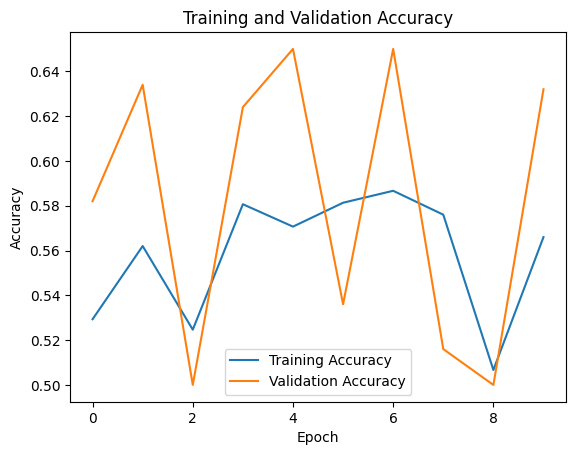

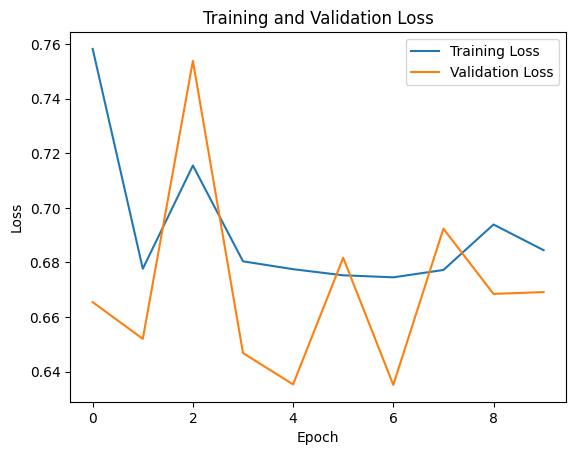

In [55]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

For Training Sample of size 2000

In [56]:
# Clear existing data in the training directory
shutil.rmtree(train_dir)
os.makedirs(train_dir, exist_ok=True)

train_cats_dir = os.path.join(train_dir, 'cat')
os.makedirs(train_cats_dir, exist_ok=True)
train_dogs_dir = os.path.join(train_dir, 'dog')
os.makedirs(train_dogs_dir, exist_ok=True)

# Assign 500 cat and 500 dog images to the training directory
def copy_images(source_dir, destination_dir, images):
    for image in images:
        shutil.copy(os.path.join(source_dir, image), destination_dir)

# Randomize the order of cat and dog images
random.shuffle(cat_images)
random.shuffle(dog_images)

# Copy images to training directory
copy_images(cat_folder_path, train_cats_dir, cat_images[:1000])
copy_images(dog_folder_path, train_dogs_dir, dog_images[:1000])

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators for training, validation, and testing
batch_size = 20
image_size = (150, 150)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


In [57]:
# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

Training The Model

In [58]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=2000 // batch_size,  # 1500 images in total (1000 cat + 1000 dog)
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size
)

Epoch 1/30
100/100 [==============================] - 165s 2s/step - loss: 0.8609 - accuracy: 0.5345 - val_loss: 0.6573 - val_accuracy: 0.6020
Epoch 2/30
100/100 [==============================] - 145s 1s/step - loss: 0.7291 - accuracy: 0.5520 - val_loss: 0.6674 - val_accuracy: 0.5900
Epoch 3/30
100/100 [==============================] - 160s 2s/step - loss: 0.6793 - accuracy: 0.5765 - val_loss: 0.8207 - val_accuracy: 0.5000
Epoch 4/30
100/100 [==============================] - 144s 1s/step - loss: 0.6859 - accuracy: 0.5805 - val_loss: 0.6616 - val_accuracy: 0.5820
Epoch 5/30
100/100 [==============================] - 145s 1s/step - loss: 0.6657 - accuracy: 0.5950 - val_loss: 0.6332 - val_accuracy: 0.6500
Epoch 6/30
100/100 [==============================] - 161s 2s/step - loss: 0.6943 - accuracy: 0.5825 - val_loss: 0.6593 - val_accuracy: 0.5920
Epoch 7/30
100/100 [==============================] - 161s 2s/step - loss: 0.6828 - accuracy: 0.5645 - val_loss: 0.6378 - val_accuracy: 0.6240

In [59]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_samples // batch_size)
print("Test accuracy:", test_accuracy)

25/25 [==============================] - 26s 1s/step - loss: 0.6642 - accuracy: 0.6140
Test accuracy: 0.6140000224113464


Perfomace Metrics

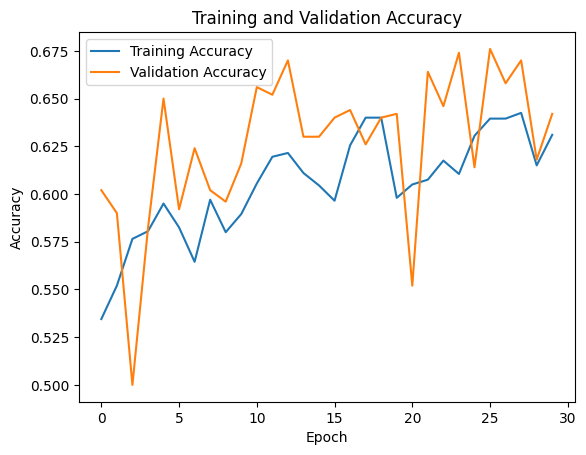

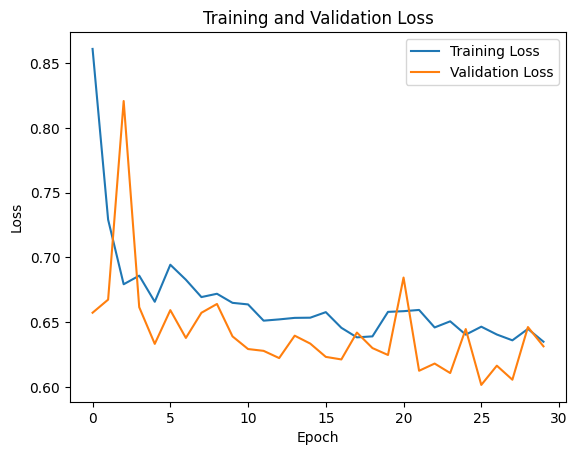

In [60]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()